# Importing Necessary Libraries

In [60]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import random as rng
from math import ceil

# Steps

1. Load Image
2. pre-process for edge detection: Grayscale the image
3. pre-process for edge detection: Reduce noise by blurring
4. Edge Detection: Canny
5. Find Contours

## 1. Loading the image

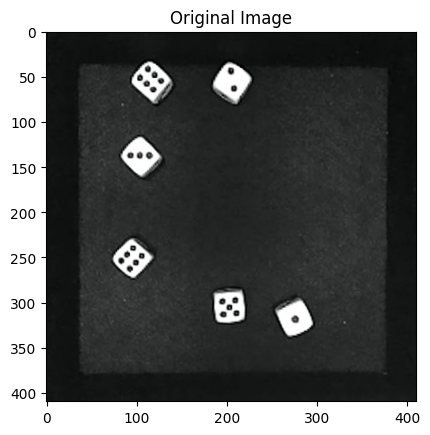

In [61]:
img_orig = cv.imread('photos/test-images/Dice (1).jpg')
plt.title('Original Image')
plt.imshow(img_orig)
plt.show()

The image uses a black background and white dice with black dots to easily process the image and find the contours of the dice and dots.

## 2. Pre-process for edge detection: Grayscale the image

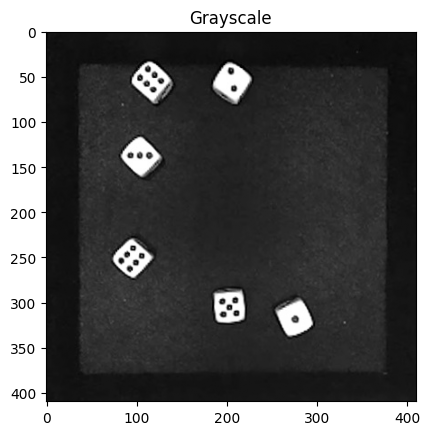

In [62]:
# Convert image to gray
img_gray = cv.cvtColor(img_orig, cv.COLOR_BGR2GRAY)
plt.title('Grayscale')
plt.imshow(img_gray, cmap='gray')
plt.show()

## 3. Pre-process for edge detection: Blurring the image to reduce noise

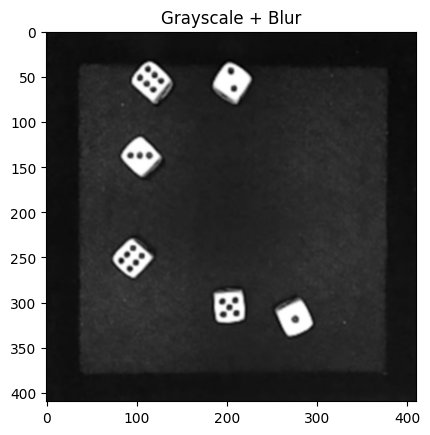

In [63]:
# Blurring the image
img_blur = cv.blur(img_gray, (3,3))
plt.title('Grayscale + Blur')
plt.imshow(img_blur, cmap='gray')
plt.show()

## 4. Edge detection using Canny

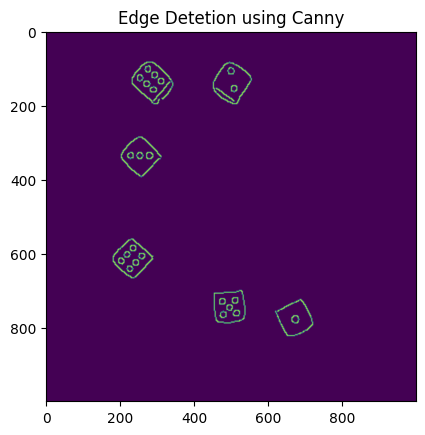

In [64]:
# Detect edges using Canny
threshold = 200
canny_output = cv.Canny(img_blur, threshold, threshold * 2)
plt.title('Edge Detetion using Canny')
plt.imshow(cv.resize(canny_output, (1000,1000)))
plt.show()

## 5. Drawing Contours

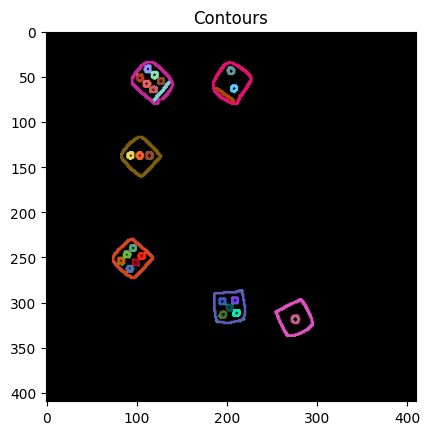

In [65]:
# Find contours
contours, hierarchy = cv.findContours(canny_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# Draw contours
rng.seed(12345)
drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)
for contour in contours:
    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    cv.drawContours(drawing, [contour], 0, color, 2, cv.LINE_8, hierarchy, 0)

plt.imshow(drawing)
plt.title('Contours')
plt.show()

The shape and dots of the dice were successfully detected, at least for the current image. As shown, the contour finding algorithm of opencv was able to detect and distinguish the shape of the dice and the dots from each other. Unfortunately, some of the side of the dice were visible to the camera and was detected by Canny. They appear as lines inside the dice in the Canny image.

## 6 Filtering Contours for dice

### 6a Finding Rectangular contours
We can use opencv's approxPolyDP to approximate the contours to simpler shapes. Then we fit a rectangle on each of the contours and filter these rectangles based on the area and dimensions of dice.

Number of rectangles found 6


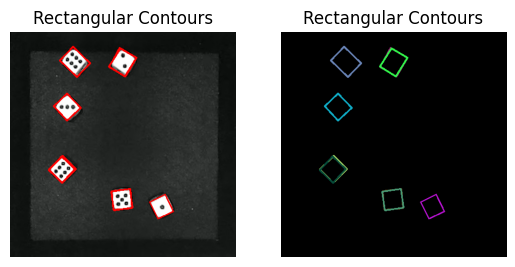

In [66]:
img_with_boxes = img_orig.copy()    # image for drawing the dice contours on original image
img_boxes_onblack = np.zeros(img_orig.shape, np.uint8)  # image for drawing the dice contours on black background

rect_coords = [] # this will store the coordinates of rectangles
for contour in contours:
    # Contour Approximation
    epsilon = 0.01*cv.arcLength(contour, True)
    approx_poly = cv.approxPolyDP(contour, epsilon, True)
    # Fitting a Rectangle
    rect = cv.minAreaRect(approx_poly)  # contains the contour points of the fitted rectangle
    box = cv.boxPoints(rect)    # converting the rectangle contour to just the (x,y) of the four corners of the rectangle
    box = np.astype(box, int)   # converting type to int
    # Computing the Area of the box
    box_area = cv.contourArea(box)
    # Filter box by area, add to dice_rects, then draw the boxes
    if box_area > 800 and box_area < 1500:
        rect_coords.append(box)
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        cv.drawContours(img_with_boxes, [box], 0, (255,0,0), 2, cv.LINE_8, hierarchy, 0)
        cv.drawContours(img_boxes_onblack, [box], 0, color, 2, cv.LINE_8, hierarchy, 0)

# print the number of rectangular contours found
print('Number of rectangles found', len(dice_rects))

# show images
plt.subplot(1,2,1)
plt.imshow(img_with_boxes)
plt.axis('off')
plt.title('Rectangular Contours')

plt.subplot(1,2,2)
plt.imshow(img_boxes_onblack)
plt.axis('off')
plt.title('Rectangular Contours')
 
plt.show()

In the images above, the shape of all the dice were found. There are only 6 dice in the image yet 9 rectangular contours were found in the image that qualify for the area of a dice.

If we take a closer look at contours in the second image, we notice that some rectangles bound the same dice. Multiple contours are describing the same dice.

To fix this, we can process the coordinates of the rectangles and remove the rectangles with same (or close) positions.

### 6b Removing similar Rectangles
Below is code for removing rectangles with center close to other rectangles.

Number of dice: 6


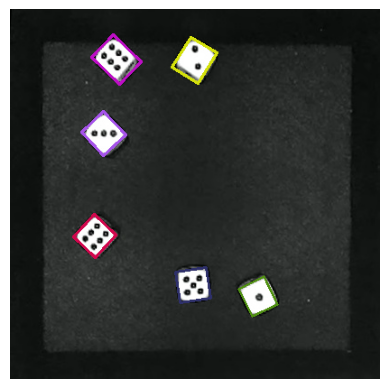

In [67]:
def remove_similar_rects(rect_coords):
    rect_coords = np.array(rect_coords)
    rect_centers = np.mean(rect_coords, axis=1)
    
    new_rects = []
    min_squared_distance = 100  # 80 percent the length of a typical dice. Most dice have area of 1000 pixels.
    mask = np.arange(len(rect_coords))
    for i, center in enumerate(rect_centers[:-1]):
        sqaured_distance_to_other_dice = (rect_centers[i+1:,0]-center[0])**2 + (rect_centers[i+1:,1]-center[1])**2
        if np.min(sqaured_distance_to_other_dice) > min_squared_distance:
            new_rects.append(rect_coords[i])
    new_rects.append(rect_coords[-1])
    
    return new_rects

# removing similar rects from earlier
dice_coords = remove_similar_rects(rect_coords)

print('Number of dice:', len(dice_coords))

# drawing the resulting rects
img_dice = img_orig.copy()
for die in dice_coords:
    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    cv.drawContours(img_dice, [die], 0, color, 2, cv.LINE_8, hierarchy, 0)

# show the images
plt.imshow(img_dice)
plt.axis('off')
plt.show()
    

It now counts the number of dice correctly.

### 6c Cropping the dice found

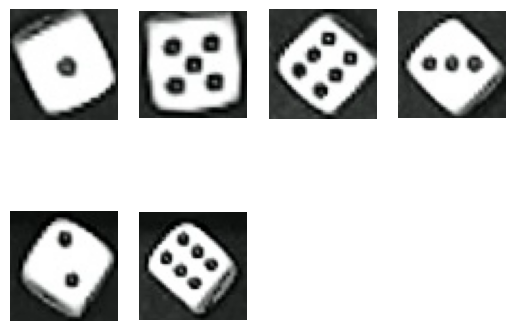

In [73]:
def crop_boxes(img, coords):
    num_of_crops = len(coords)
    box_coords = []
    for i, coord in enumerate(coords):
        x,y,w,h = cv.boundingRect(coord)
        box_coords.append([[x, y],[x+w, y+h]])

        plt.subplot(ceil(num_of_crops/4), 4, i+1)
        plt.imshow(img[y:y+h, x:x+w])
        plt.axis('off')
    plt.show()
    return

crop_boxes(img_orig, dice_coords)

def crop_box(img, coords):
    x,y,w,h = cv.boundingRect(coords)
    return img[y:y+h, x:x+w]

## 7. Counting the number of dots

### 7a Finding circular contours

In [69]:
def find_dots(img):
    img_copy = img.copy()
    # Grayscale the image
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Blurring the image
    img_blur = cv.blur(img_gray, (3,3))
    # Detect edges using Canny
    threshold = 200
    canny_output = cv.Canny(img_blur, threshold, threshold * 2)
    # Find Contours
    contours, hierarchy = cv.findContours(canny_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    # Draw Contours
    img_contours = np.zeros(img.shape, np.uint8)

    dots_coords = []
    for contour in contours:
        # Contour Approximation
        epsilon = 0.01*cv.arcLength(contour, True)
        approx_poly = cv.approxPolyDP(contour, epsilon, True)
        # Bounding Circle
        (x, y), radius = cv.minEnclosingCircle(contour)
        # Filter circles by radius
        max_radius = 7
        if radius > 3 and radius < max_radius:
            dots_coords.append([x, y, radius])
            color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
            cv.drawContours(img_copy, [approx_poly], 0, color, 1, cv.LINE_8, hierarchy, 0)

    plt.subplot(1,2,1)
    plt.imshow(img)

    plt.subplot(1,2,2)
    plt.imshow(img_copy)

    plt.show()
    return dots_coords

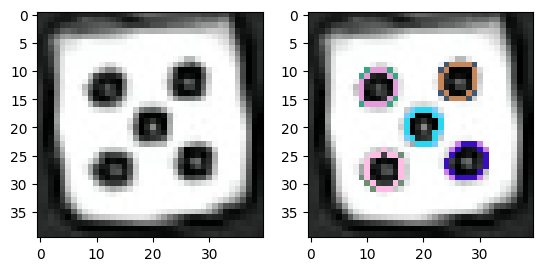

Number of circular contours found: 10


In [80]:
die = crop_box(img_orig, dice_coords[1])
dots_coords = find_dots(die)
print('Number of circular contours found:', len(dots_coords))

The function found ten circular contours but most of these contours describe the same dot. Let's remove the other contours.

### 7b Removing similar contours

In [78]:
def remove_similar_circs(circ_coords):
    circ_coords = np.array(circ_coords)
    centers = circ_coords[:,0:2]
    
    new_dots = []
    min_distance = 8
    mask = np.arange(len(circ_coords))
    for i, center in enumerate(centers[:-1]):
        sqaured_distance_to_other_dice = (centers[i+1:,0]-center[0])**2 + (centers[i+1:,1]-center[1])**2
        if np.min(sqaured_distance_to_other_dice) > min_distance:
            new_dots.append(circ_coords[i])
    new_dots.append(circ_coords[-1])
    
    return len(new_dots)

In [79]:
print('Number of dice:', remove_similar_circs(dots_coords))

Number of dice: 5


The method above worked really well. The dice were found and the number of dots on each dice were counted correctly.